In [1]:
import numpy as np
import matplotlib.pyplot as plt
from gym_gridworlds.algos.policy_iteration import PolicyIteration
from gym_gridworlds.utils.env_specs import get_env_specs
from gym_gridworlds.utils.plotting import plot_policy, plot_values


ENV_NAME = "Gym-Gridworlds/Penalty-3x3-v0"
GAMMAS = [0.99]
INITIALIZATION_VALUES = [-100, -10, -5, 0, 5, 10, 100]
THETA = 0.01
GPI_ITERATIONS = 5
OPT_POLICY = np.array(
    [
        [0, 1, 0, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1],
        [0, 1, 0, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0],
    ]
)

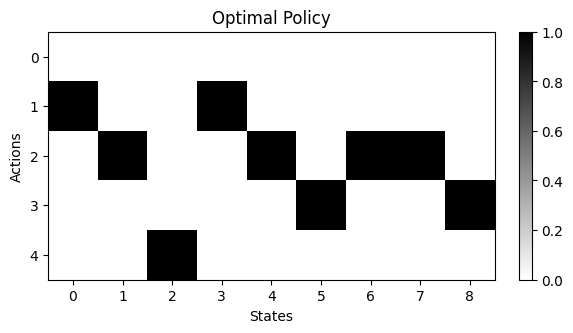

In [2]:
plot_policy(policy=OPT_POLICY, title="Optimal Policy")

In [3]:
R, P, T, n_states, n_actions = get_env_specs(name=ENV_NAME)

vi_results = {gamma: {init_value: {} for init_value in INITIALIZATION_VALUES} for gamma in GAMMAS}
pi_results = {gamma: {init_value: {} for init_value in INITIALIZATION_VALUES} for gamma in GAMMAS}
gpi_results = {gamma: {init_value: {} for init_value in INITIALIZATION_VALUES} for gamma in GAMMAS}

for gamma in GAMMAS:
    for init_value in INITIALIZATION_VALUES:
        evaluator = PolicyIteration(
            gamma=gamma,
            rewards=R,
            transitions=P,
            terminal=T,
            n_states=n_states,
            n_actions=n_actions,
            initialization=init_value
        )
        learned_policy, errors, n_evals = evaluator.policy_iteration(threshold=THETA)
        assert np.allclose(OPT_POLICY, learned_policy)
        pi_results[gamma][init_value] = {
            'policy': learned_policy,
            'errors': errors,
            'n_evals': n_evals
        }

        evaluator._reset()
        values, errors = evaluator.loop_value_iteration(threshold=THETA)
        assert np.allclose(OPT_POLICY, learned_policy)
        vi_results[gamma][init_value] = {
            'values': values,
            'errors': errors
        }

        evaluator._reset()
        values, errors, n_evals = evaluator.policy_iteration(threshold=THETA, n_iter=GPI_ITERATIONS)
        assert np.allclose(OPT_POLICY, learned_policy)
        gpi_results[gamma][init_value] = {
            'values': values,
            'errors': errors,
            'n_evals': n_evals
        }

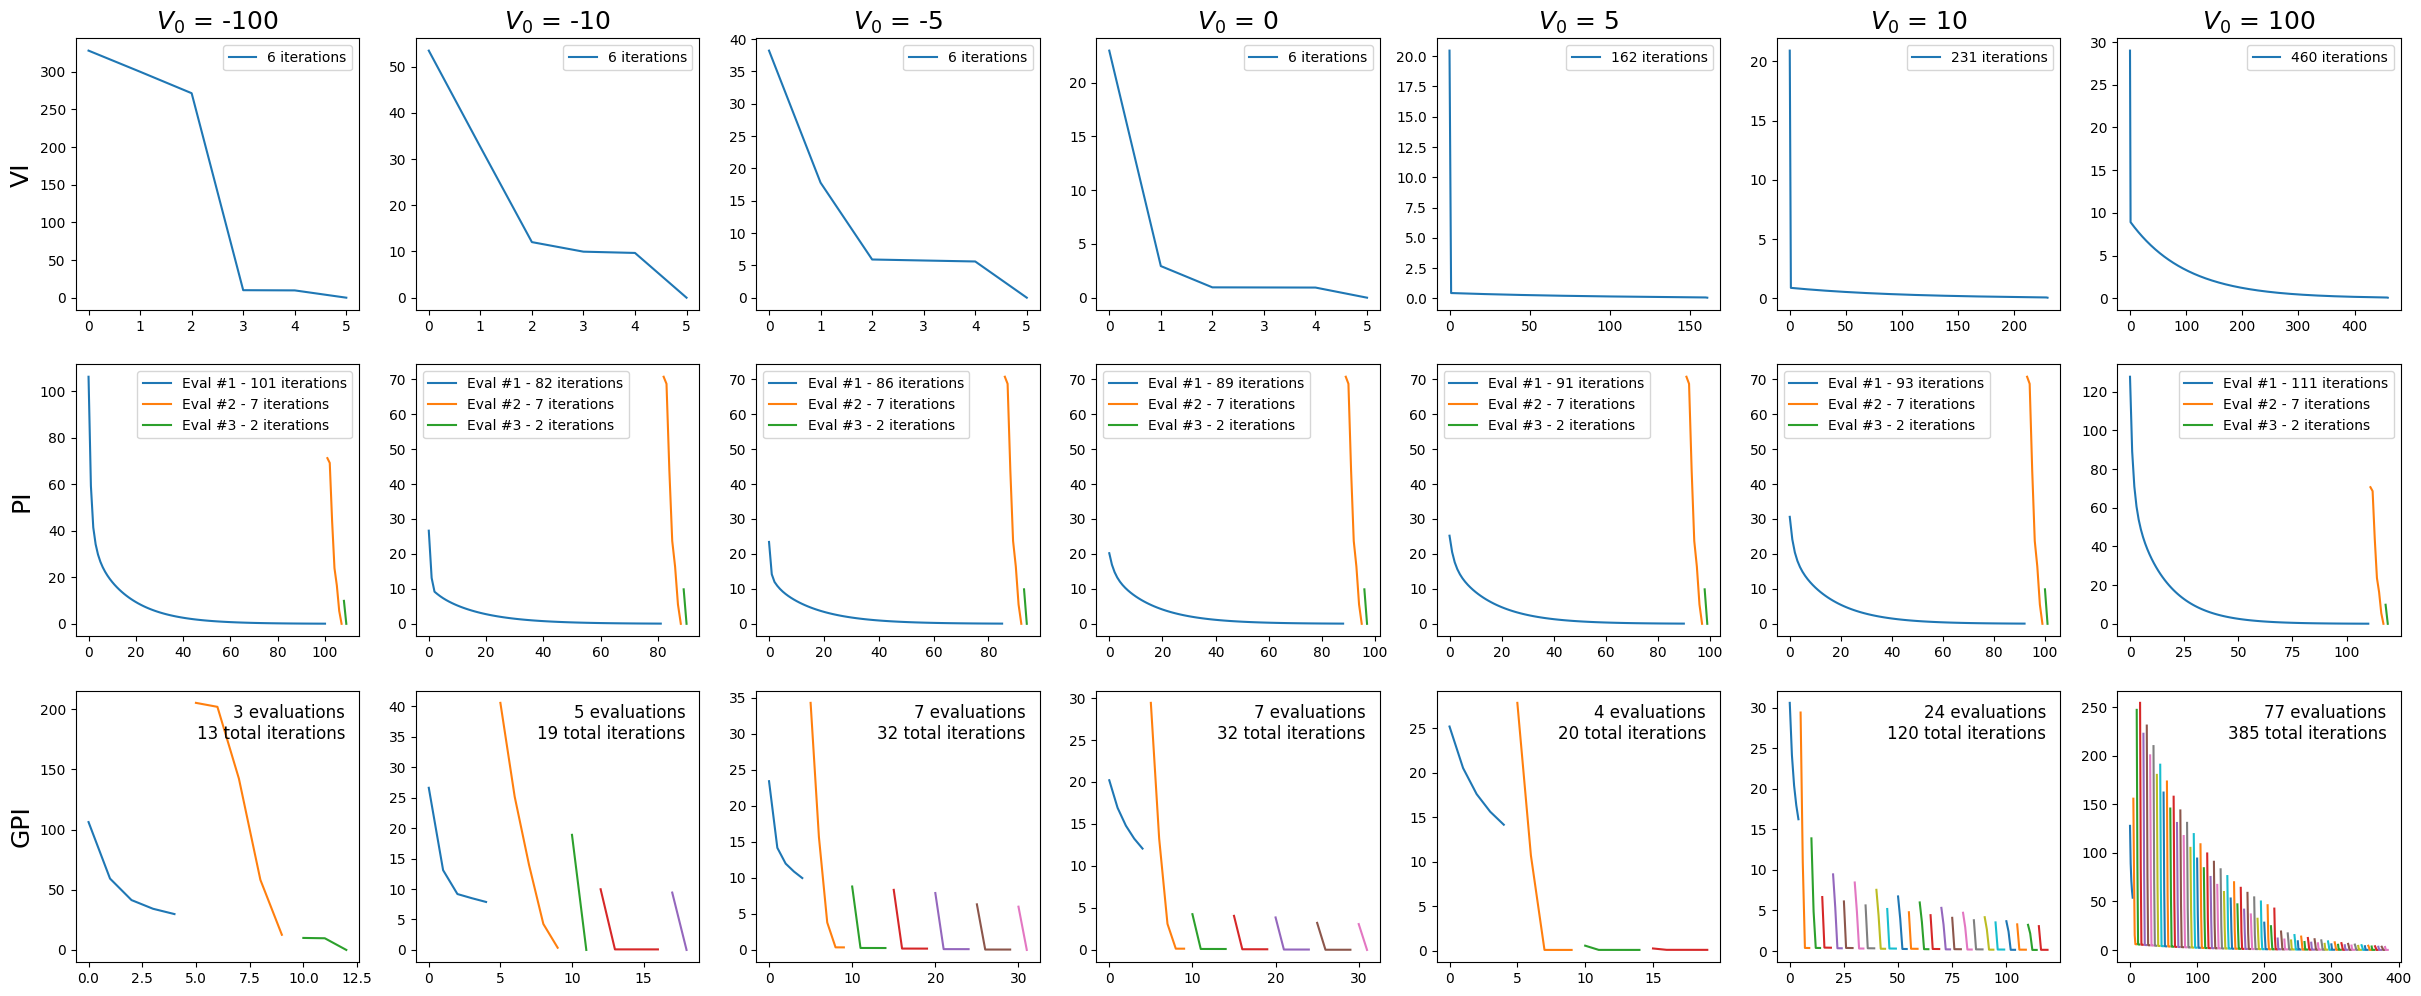

In [4]:

tot_iter_table = np.zeros((3, 7))
fig, axs = plt.subplots(3, 7, figsize=(30, 12))
for i, init_value in enumerate(INITIALIZATION_VALUES):
    # axs[0][i].set_title(f'$V_0$ = {init_value}')
    axs[0][i].set_title(f'$V_0$ = {init_value}', fontsize=18)

    x_offset = 0
    be = vi_results.get(GAMMAS[0]).get(init_value).get('errors')
    axs[0][i].plot(be, label=f'{len(be)} iterations')
    axs[0][i].legend()
    tot_iter_table[0][i] = len(be)

    x_offset = 0
    be = pi_results.get(GAMMAS[0]).get(init_value).get('errors')
    for iteration_idx, data in enumerate(be):
        axs[1][i].plot(range(x_offset, x_offset + data.size), data, label=f'Eval #{iteration_idx+1} - {data.size} iterations')
        x_offset += data.size
        axs[1][i].legend()
    tot_iter_table[1][i] = x_offset

    x_offset = 0
    be = gpi_results.get(GAMMAS[0]).get(init_value).get('errors')
    for iteration_idx, data in enumerate(be):
        line, = axs[2][i].plot(range(x_offset, x_offset + data.size), data)
        x_offset += data.size
    tot_iter_table[2][i] = x_offset
    axs[2][i].text(
        0.95, 0.95,  # x and y positions in relative coordinates (0 to 1)
        f"{len(be)} evaluations\n{x_offset} total iterations",  # Text
        transform=axs[2][i].transAxes,  # Use relative coordinates
        fontsize=12,
        verticalalignment='top',  # Align the text to the top
        horizontalalignment='right'  # Center the text horizontally
    )

    if i == 0:
        # axs[i].set_ylabel("PI", fontsize=18)
        axs[0][i].set_ylabel("VI", fontsize=18)
        axs[1][i].set_ylabel("PI", fontsize=18)
        axs[2][i].set_ylabel("GPI", fontsize=18)

plt.show()

In [5]:
import pandas as pd
pd.DataFrame(
    [[f"{mean:.2f} ± {std:.2f}"] for mean, std in zip(tot_iter_table.mean(axis=1), tot_iter_table.std(axis=1))],
    index = ["VI", "PI", "GPI"],
    columns = ["Mean ± Std"]
    )

,Mean ± Std
VI,125.29 ± 161.01
PI,102.29 ± 9.08
GPI,88.71 ± 125.65
